Hier alle imports gewoon plaatsen denk ik, zouden het ook kunnen doen per deel maar niet dat het in random codeblocks staat

**Statlines**
- Bevolking = https://opendata.cbs.nl/#/CBS/nl/dataset/37230ned/table?dl=A564B 2019-2023 Niet gebruikt
- Inkomen = https://opendata.cbs.nl/#/CBS/nl/dataset/86005NED/table?dl=9552C 2021 Niet gebruikt
- Woningen = https://opendata.cbs.nl/#/CBS/nl/dataset/85035NED/table?dl=B40B6 2021
- Zon = https://opendata.cbs.nl/#/CBS/nl/dataset/85005NED/table?dl=B3FBC 2019-2021
- Inkomen & Leeftijd & Bevolking & Onderwijs & oppervlaktes samen = https://opendata.cbs.nl/#/CBS/nl/dataset/70072ned/table?dl=B40C8 2019-2023 (Nu gebruikt)
- Dichtheid kan je uitrekenen met oppervlakte en woningen
- Missend zijn subsidie en dakorientatie

IAPES (engels) wordt gebruikt voor de DF met Inkomen, leeftijd, Bevolking, onderwijs, oppervlaktes

In [33]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [34]:
# Path to the relevant geofiles
municipality_shapefile = "data/geo/gemeente_2020_v3.shp"

# Path to the relevant files
housing_type_path = "data/woningtype_nieuw.csv"
solar_path = "data/zonnestroom.csv"
IAPES_path = "data/IAPES.csv"

In [35]:
# Reading the shapefile as a GeoDataFrame
geo_df = gpd.read_file(municipality_path)


# Reading the other datasets as DataFrames
housing_type_df = pd.read_csv(housing_type_path, header=0, delimiter=';')
solar_df = pd.read_csv(solar_path, header=0, delimiter=';')
IAPES_df = pd.read_csv(IAPES_path, header=0, delimiter=';')


In [36]:
display(geo_df)

,GM_CODE,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,...,AV20PODIUM,AF_MUSEUM,AV5_MUSEUM,AV10MUSEUM,AV20MUSEUM,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry
0,GM0010,Delfzijl,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2020GM0010,2020,128728.007061,9.129235e+07,"MULTIPOLYGON (((268674.309 592382.331, 268667...."
1,GM0034,Almere,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2020GM0034,2020,122665.358634,1.095623e+08,"MULTIPOLYGON (((150213.998 479503.726, 150087...."
2,GM0050,Zeewolde,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2020GM0050,2020,83290.773617,1.633050e+07,"MULTIPOLYGON (((154927.535 474979.29, 154931.2..."
3,GM0060,Ameland,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2020GM0060,2020,156406.894023,2.085914e+08,"POLYGON ((196000 610000, 196000 608000, 195250..."
4,GM0072,Harlingen,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999.0,-99999999.0,-99999999.0,-99999999.0,-99999999.0,2020GM0072,2020,104274.683036,3.618323e+08,"MULTIPOLYGON (((158392.775 580357.5, 158387.71..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,GM1963,Hoeksche Waard,NEE,825,4,325,87401,43211,44190,16,...,9.8,7.9,0.2,1.0,10.4,2020GM1963,2020,147020.366016,2.818623e+08,"MULTIPOLYGON (((98666.226 412682.437, 98543 41..."
434,GM1966,Het Hogeland,NEE,410,5,99,47801,24042,23759,15,...,3.3,5.9,0.4,1.7,7.0,2020GM1966,2020,323086.469173,4.878506e+08,"MULTIPOLYGON (((215169.098 595155.688, 215169...."
435,GM1969,Westerkwartier,NEE,475,5,175,63329,31810,31519,17,...,5.6,5.2,0.8,2.4,12.9,2020GM1969,2020,99030.762281,3.688457e+08,"POLYGON ((211363.51 585818.36, 211364.156 5858..."
436,GM1970,Noardeast-FryslÃ¢n,NEE,463,5,120,45228,22768,22460,17,...,1.2,4.6,0.7,1.9,7.5,2020GM1970,2020,238426.959616,3.837930e+08,"MULTIPOLYGON (((207521.119 595796.903, 207521...."


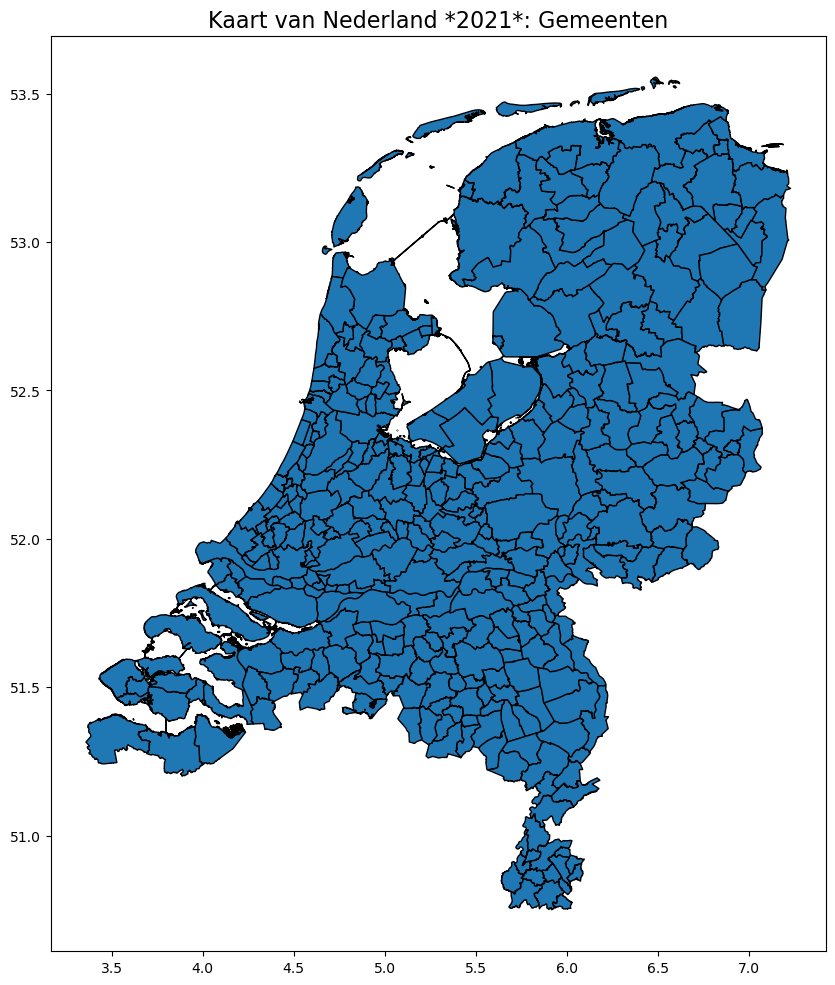

In [51]:
# Laad de shapefile met GeoPandas
gdf_municipalities = gpd.read_file(municipality_shapefile)

gdf_municipalities.to_crs(epsg=4326, inplace=True)

# Filter for only municipalities (no water) and the year 2021
filtered_gdf_municipalities = gdf_municipalities[(gdf_municipalities['H2O'] == 'NEE')]

# Plot de kaart van Nederland met gemeenten
filtered_gdf_municipalities.plot(edgecolor='black', figsize=(10, 12))

plt.title("Kaart van Nederland *2021*: Gemeenten", fontsize=16)
plt.show()

In [27]:
display(housing_type_df)

,Regio's,Woningtype,Perioden,Beginstand woningvoorraad (aantal)
0,Nederland,Totaal woningen,2021,7966331.0
1,Nederland,Meergezinswoningen totaal,2021,2870532.0
2,Nederland,Eengezinswoningen totaal,2021,5095799.0
3,Nederland,Vrijstaande woning,2021,1035389.0
4,Nederland,2-onder-1-kapwoning,2021,698022.0
...,...,...,...,...
2859,Buitenland,Vrijstaande woning,2021,NaN
2860,Buitenland,2-onder-1-kapwoning,2021,NaN
2861,Buitenland,Hoekwoning,2021,NaN
2862,Buitenland,Tussenwoning,2021,NaN


In [28]:
# Get unique woningtypes from the 'Woningtype' column
unique_woningen = housing_type_df['Woningtype'].unique()

# Print the unique woningtypes
print("Unieke woningtypes in de kolom 'Woningtype':")
for woning in unique_woningen:
    print(woning)

Unieke woningtypes in de kolom 'Woningtype':
Totaal woningen
Meergezinswoningen totaal
Eengezinswoningen totaal
Vrijstaande woning
2-onder-1-kapwoning
Hoekwoning
Tussenwoning
Onbekend woningtype eengezinswoning


In het begin werkten de tabellen kut maar met andere download is dit niet echt meer nodig. Moest unstacken

# Beschrijving van de Dataset

## Inhoud
De dataset bevat informatie over woningtypes in Nederland en hun aantallen per categorie. Het doel is om inzicht te geven in de verdeling van verschillende woningtypes en hun kenmerken, zoals het totale aantal woningen en de onderverdeling in specifieke categorieën.
### Belangrijke Kolommen
1. **Regio's**: De geografische regio's, zoals gemeenten of Nederland als geheel.
2. **Woningtype**: Het type woning.
3. **Perioden**: Het jaar waarop de data betrekking heeft (bijvoorbeeld 2021).
4. **Beginstand woningvoorraad (aantal)**: Het aantal woningen aan het begin van de periode.

#### **- Totaal woningen**
- **Type woning**: Overkoepelende categorie die alle woningtypes omvat, inclusief zowel eengezins- als meergezinswoningen.
- **Invloed op zonnepanelen**: Dit is een aggregaatcategorie, dus de invloed varieert afhankelijk van het specifieke woningtype.

#### **- Meergezinswoningen totaal**
- **Type woning**: Woningen in een gebouw dat meerdere huishoudens huisvest, zoals flats en appartementen.
- **Invloed op zonnepanelen**:
  - Het dak wordt gedeeld door meerdere huishoudens, waardoor individuele plaatsing niet mogelijk is.
  - Plaatsing vereist samenwerking via bijvoorbeeld een Vereniging van Eigenaren (VvE) of een collectief project.

#### **- Eengezinswoningen totaal**
- **Type woning**: Grondgebonden woningen bedoeld voor één huishouden, waaronder vrijstaande woningen, hoekwoningen, tussenwoningen en twee-onder-een-kapwoningen.
- **Invloed op zonnepanelen**:
  - Dak is meestal volledig in eigendom van het huishouden.
  - Ideaal voor individuele plaatsing van zonnepanelen zonder organisatorische beperkingen.

#### **- Vrijstaande woning**
- **Type woning**: Een woning die volledig vrijstaat, zonder gemeenschappelijke muren met andere woningen.
- **Invloed op zonnepanelen**:
  - Het hele dak is beschikbaar voor zonnepanelen.
  - Geen schaduw van aangrenzende gebouwen; maximale flexibiliteit in plaatsing.

#### **- 2-onder-1-kapwoning**
- **Type woning**: Twee woningen die samen één gebouw vormen en een gemeenschappelijke muur delen.
- **Invloed op zonnepanelen**:
  - Elk huishouden heeft zijn eigen dakhelft, wat zelfstandige plaatsing mogelijk maakt.
  - Dakoriëntatie kan verschillen per woning, wat de opbrengst kan beïnvloeden.

#### **- Hoekwoning**
- **Type woning**: Een woning aan het uiteinde van een rij, vaak met extra buitenruimte en een zijmuur.
- **Invloed op zonnepanelen**:
  - Dak is eigendom van de bewoner, zonder gedeelde eigendomsrechten.
  - Minder kans op schaduw van aangrenzende woningen, vooral aan de vrije zijde.

#### **- Tussenwoning**
- **Type woning**: Een woning die zich in het midden van een rij woningen bevindt, met muren aan beide zijden gedeeld met buren.
- **Invloed op zonnepanelen**:
  - Het dak is eigendom van de bewoner, maar de beschikbare ruimte is vaak beperkt.
  - Mogelijke schaduw van aangrenzende woningen kan de opbrengst beïnvloeden.

# Conclusie
Voor de analyse wordt onderscheid gemaakt tussen twee woningtypes: **Eengezinswoningen totaal** en **Meergezinswoningen totaal**

In [29]:
# Unstacking based on 'Woningtype'
housing_type_df = housing_type_df.pivot_table(
    index=["Regio's", 'Perioden'], 
    columns='Woningtype', 
    values='Beginstand woningvoorraad (aantal)'
).reset_index()

display(housing_type_df)

Woningtype,Regio's,Perioden,2-onder-1-kapwoning,Eengezinswoningen totaal,Hoekwoning,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning,Totaal woningen,Tussenwoning,Vrijstaande woning
0,'s-Gravenhage (gemeente),2021,3063.0,56307.0,9259.0,209652.0,10.0,265959.0,41662.0,2313.0
1,'s-Hertogenbosch,2021,3850.0,44343.0,9400.0,29081.0,16.0,73424.0,25311.0,5766.0
2,Aa en Hunze,2021,2621.0,10262.0,925.0,945.0,1.0,11207.0,1149.0,5566.0
3,Aalsmeer,2021,1111.0,10389.0,2339.0,2895.0,5.0,13284.0,4972.0,1962.0
4,Aalten,2021,2313.0,9893.0,1914.0,2135.0,4.0,12028.0,2587.0,3075.0
...,...,...,...,...,...,...,...,...,...,...
348,Zundert,2021,1742.0,8420.0,1116.0,1229.0,2.0,9649.0,1679.0,3881.0
349,Zutphen,2021,1802.0,15234.0,3587.0,7417.0,7.0,22651.0,8361.0,1477.0
350,Zwartewaterland,2021,1428.0,7917.0,1766.0,1096.0,39.0,9013.0,3180.0,1504.0
351,Zwijndrecht,2021,744.0,12479.0,3345.0,8241.0,12.0,20720.0,7718.0,660.0


In [32]:
# Stap 3: Filteren op hoekwoning en tussenwoning met behoud van index
housing_type_df_filtered = housing_type_df[["Regio's", "Perioden", "Eengezinswoningen totaal", "Meergezinswoningen totaal", "Onbekend woningtype eengezinswoning"]]

display(housing_type_df_filtered)

Woningtype,Regio's,Perioden,Eengezinswoningen totaal,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning
0,'s-Gravenhage (gemeente),2021,56307.0,209652.0,10.0
1,'s-Hertogenbosch,2021,44343.0,29081.0,16.0
2,Aa en Hunze,2021,10262.0,945.0,1.0
3,Aalsmeer,2021,10389.0,2895.0,5.0
4,Aalten,2021,9893.0,2135.0,4.0
...,...,...,...,...,...
348,Zundert,2021,8420.0,1229.0,2.0
349,Zutphen,2021,15234.0,7417.0,7.0
350,Zwartewaterland,2021,7917.0,1096.0,39.0
351,Zwijndrecht,2021,12479.0,8241.0,12.0


In [106]:
# def fix_columns(df, add_unit=True):
#     # Adjust the headers
#     # Extract row 0 values for column names
#     row_0 = df.iloc[0]

#     # Set new column names
#     new_column_names = [
#         "Perioden" if idx == 0 else
#         "Regio's" if idx == 1 else
#         (f"{df.columns[idx]} ({row_0[idx]})" if add_unit else df.columns[idx])
#         for idx in range(len(df.columns))
#     ]

#     # Update the DataFrame with the new headers
#     df.columns = new_column_names

#     # Drop the first row (row 0)
#     df = solar_df[1:]

#     # Reset index for clarity
#     df.reset_index(drop=True, inplace=True)

#     return df

# housing_type_df = fix_columns(housing_type_df)
# solar_df = fix_columns(solar_df)

In [108]:
display(solar_df)

,Sector en vermogensklasse,Regio's,Perioden,Installaties (aantal),Opgesteld vermogen van zonnepanelen (kWp),Opgesteld vermogen omvormers (kW),Productie van zonnestroom (mln kWh)
0,Alle economische activiteit en woningen,Nederland,2019,1062265.0,7225864.0,NaN,5399
1,Alle economische activiteit en woningen,Nederland,2020,1383888.0,11108427.0,NaN,8567
2,Alle economische activiteit en woningen,Nederland,2021,1730285.0,14822880.0,NaN,11304
3,Alle economische activiteit en woningen,Nederland,2022,2298859.0,19536096.0,17451365.0,16659
4,Alle economische activiteit en woningen,Aa en Hunze,2019,2922.0,20968.0,NaN,.
...,...,...,...,...,...,...,...
1443,Alle economische activiteit en woningen,Zwolle,2022,19666.0,172154.0,150845.0,.
1444,Alle economische activiteit en woningen,Gemeenten; niet in te delen,2019,359.0,1303.0,NaN,1
1445,Alle economische activiteit en woningen,Gemeenten; niet in te delen,2020,432.0,1823.0,NaN,1
1446,Alle economische activiteit en woningen,Gemeenten; niet in te delen,2021,426.0,14389.0,NaN,12


In [109]:
display(IAPES_df)

,Perioden,Regio's,Bevolking/Bevolkingssamenstelling op 1 januari/Totale bevolking (aantal),"Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/Jonger dan 5 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/5 tot 10 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/10 tot 15 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/15 tot 20 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/20 tot 25 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/25 tot 45 jaar (%)","Bevolking/Bevolkingssamenstelling op 1 januari/Leeftijd/Leeftijdsgroepen, relatief/45 tot 65 jaar (%)",...,Onderwijs/Naar woongemeente/Gediplomeerden/Voortgezet onderwijs (aantal),Onderwijs/Naar woongemeente/Gediplomeerden/Middelbaar beroepsonderwijs (aantal),Onderwijs/Naar woongemeente/Gediplomeerden/Hoger beroepsonderwijs bachelor (aantal),Onderwijs/Naar woongemeente/Gediplomeerden/Wo master/doctoraal (aantal),Inkomen en vermogen/Inkomen van particuliere huishoudens/Gemiddeld besteedbaar inkomen/Particuliere huishoudens excl. studenten (1 000 euro),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Totale oppervlakte (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Land (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Water/Water totaal (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Water/Binnenwater (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Water/Buitenwater (km²)
0,2019,Nederland,17282163.0,5.0,5.3,5.5,6.1,6.2,24.6,28.0,...,191088.0,154637.0,67459.0,42635.0,46.8,41543.38,33671.09,7872.28,3719.65,4152.64
1,2020,Nederland,17407585.0,4.9,5.2,5.5,6.0,6.3,24.8,27.8,...,177672.0,157401.0,71355.0,47811.0,47.5,41543.38,33671.09,7872.28,3719.65,4152.64
2,2021,Nederland,17475415.0,4.9,5.1,5.5,5.9,6.3,24.9,27.6,...,167405.0,152039.0,66451.0,47868.0,49.5,41543.38,33671.09,7872.28,3719.65,4152.64
3,2022,Nederland,17590672.0,4.9,5.1,5.4,5.8,6.4,25.0,27.3,...,NaN,NaN,NaN,NaN,52.0,41543.37,33647.23,7896.14,3744.03,4152.11
4,2023,Nederland,17811291.0,4.9,5.0,5.4,5.7,6.6,25.3,26.9,...,NaN,NaN,NaN,NaN,NaN,41543.37,33647.23,7896.14,3744.03,4152.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,2019,Zwolle,127497.0,5.6,6.1,6.0,6.1,6.7,28.3,25.5,...,1394.0,1151.0,819.0,122.0,44.4,119.36,111.10,8.26,8.26,0.00
3636,2020,Zwolle,128840.0,5.5,6.0,6.1,6.0,6.8,28.2,25.5,...,1400.0,1157.0,896.0,133.0,45.6,119.36,111.10,8.26,8.26,0.00
3637,2021,Zwolle,129840.0,5.4,5.8,6.0,6.0,6.8,28.2,25.4,...,1447.0,1129.0,783.0,143.0,47.4,119.36,111.10,8.26,8.26,0.00
3638,2022,Zwolle,130668.0,5.4,5.6,6.0,6.0,7.0,28.2,25.3,...,NaN,NaN,NaN,NaN,50.2,119.36,110.67,8.69,8.69,0.00


In [110]:
# Filtering for 2021
housing_type_df_2021 = housing_type_df[housing_type_df['Perioden'] == 2021]
solar_df_2021 = solar_df[solar_df['Perioden'] == 2021]
IAPES_df_2021 = IAPES_df[IAPES_df['Perioden'] == 2021]

# Merging on 'Regio's'
merged_df = housing_type_df_2021.merge(
    solar_df_2021, on="Regio's", suffixes=('_housing', '_solar')
).merge(
    IAPES_df_2021, on="Regio's", suffixes=('', '_IAPES')
)

Als je merged verlies je 1448/4=362 362-353 (kijk naar rij aantallen)=9 gemeenten, waaraan weet ik nog niet. Huisdata lijkt iig het minste aantal gemeenten te hebben, wel staan in veel oude cijfers gemeenten nog wel maar zonder data. Na een kleine google kom ik op 352 gemeenten nodig in 2021, en aangezien Nederland er ook bij zit klopt 353 precies (bron https://allecijfers.nl/definities/aantal-gemeenten-en-overzicht-gemeentelijkeherindelingen/)

In [111]:
display(merged_df)

,Regio's,Perioden_housing,2-onder-1-kapwoning,Eengezinswoningen totaal,Hoekwoning,Meergezinswoningen totaal,Onbekend woningtype eengezinswoning,Totaal woningen,Tussenwoning,Vrijstaande woning,...,Onderwijs/Naar woongemeente/Gediplomeerden/Voortgezet onderwijs (aantal),Onderwijs/Naar woongemeente/Gediplomeerden/Middelbaar beroepsonderwijs (aantal),Onderwijs/Naar woongemeente/Gediplomeerden/Hoger beroepsonderwijs bachelor (aantal),Onderwijs/Naar woongemeente/Gediplomeerden/Wo master/doctoraal (aantal),Inkomen en vermogen/Inkomen van particuliere huishoudens/Gemiddeld besteedbaar inkomen/Particuliere huishoudens excl. studenten (1 000 euro),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Totale oppervlakte (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Land (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Water/Water totaal (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Water/Binnenwater (km²),Milieu en bodemgebruik/Bodemgebruik/Oppervlakte/Water/Buitenwater (km²)
0,'s-Gravenhage (gemeente),2021,3063.0,56307.0,9259.0,209652.0,10.0,265959.0,41662.0,2313.0,...,4530.0,4090.0,2148.0,1658.0,46.3,98.13,82.45,15.68,3.08,12.6
1,'s-Hertogenbosch,2021,3850.0,44343.0,9400.0,29081.0,16.0,73424.0,25311.0,5766.0,...,1401.0,1196.0,720.0,238.0,50.0,117.81,109.99,7.82,7.82,0.0
2,Aa en Hunze,2021,2621.0,10262.0,925.0,945.0,1.0,11207.0,1149.0,5566.0,...,245.0,252.0,91.0,17.0,51.8,278.87,276.09,2.79,2.79,0.0
3,Aalsmeer,2021,1111.0,10389.0,2339.0,2895.0,5.0,13284.0,4972.0,1962.0,...,405.0,227.0,87.0,30.0,61.4,32.29,20.12,12.17,12.17,0.0
4,Aalten,2021,2313.0,9893.0,1914.0,2135.0,4.0,12028.0,2587.0,3075.0,...,291.0,284.0,90.0,11.0,48.0,97.05,96.54,0.52,0.52,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,Zundert,2021,1742.0,8420.0,1116.0,1229.0,2.0,9649.0,1679.0,3881.0,...,172.0,173.0,89.0,19.0,52.7,121.21,120.65,0.56,0.56,0.0
349,Zutphen,2021,1802.0,15234.0,3587.0,7417.0,7.0,22651.0,8361.0,1477.0,...,491.0,470.0,124.0,30.0,44.7,42.93,40.95,1.98,1.98,0.0
350,Zwartewaterland,2021,1428.0,7917.0,1766.0,1096.0,39.0,9013.0,3180.0,1504.0,...,315.0,273.0,95.0,23.0,54.6,87.86,82.49,5.37,5.37,0.0
351,Zwijndrecht,2021,744.0,12479.0,3345.0,8241.0,12.0,20720.0,7718.0,660.0,...,463.0,390.0,103.0,36.0,47.1,22.77,20.30,2.47,2.47,0.0
